### This file decribes how to get scrape a working csv-file from wikinews.org

# IT NEED A LOT OF STUFF NOT IMPLEMENTED COMPLITELY

Table taken from: https://github.com/several27/FakeNewsCorpus - go there for better table formating

| Type | Tag | Count (so far) | Description|
| ------------- |-------------|:-------------:|:-------------:|
| **Fake News** | fake | 928,083 | Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports |
| **Satire** | satire | 146,080 | Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events. |
| **Extreme Bias** | bias | 1,300,444 | Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts. |
| **Conspiracy Theory** | conspiracy | 905,981 | Sources that are well-known promoters of kooky conspiracy theories. |
| **State News** | state | 0 | Sources in repressive states operating under government sanction. |
| **Junk Science** | junksci | 144,939 | Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims. |
| **Hate News** | hate | 117,374 | Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination. |
| **Clickbait** | clickbait | 292,201 | Sources that provide generally credible content, but use exaggerated, misleading, or questionable headlines, social media descriptions, and/or images. |
| **Proceed With Caution** | unreliable | 319,830 | Sources that may be reliable but whose contents require further verification. |
| **Political** | political | 2,435,471 | Sources that provide generally verifiable information in support of certain points of view or political orientations. |
| **Credible** | reliable | 1,920,139 | Sources that circulate news and information in a manner consistent with traditional and ethical practices in journalism (Remember: even credible sources sometimes rely on clickbait-style headlines or occasionally make mistakes. No news organization is perfect, which is why a healthy news diet consists of multiple sources of information). |

In [1]:
# Follow the link below:
# https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
# https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

import psycopg2
import nltk
import pandas as pd
import numpy as np
import re
import string

### Import and get basic information about the data

First we import the data and get an idea about how it it structured and so on such that we can better understand what has to be done.

- Below we import and create a type_id colum (might remove later)


In [4]:
# specifying return files after the cleaning proces
return_file = '../Data_git_ignore/ml_dataset.csv'


# importing and creating df (has to have type_id)

# usage: specify file location, sample size and seed(used by random) 
filepath = '../Data_git_ignore/1mio-raw.csv' # 250 rows of FakeNewsCorpus
s = 1000000                                            # desired sample size
seed = 1                                           # seed used by Pseudorandom number generator

df = pd.read_csv(filepath, index_col = [0]).sample(n=s, random_state=seed)
df["content"] = df["content"].astype(str)
# create type_id
df['type_id'] = df.groupby(['type']).ngroup()

df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,type_id
6803,322758,zerohedge.com,conspiracy,https://www.zerohedge.com/news/2014-12-17/new-...,Submitted by Mike Krieger via Liberty Blitzkri...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,59% Of Americans Support Post-9/11 Torture – P...,NaN,NaN,[''],"""By an almost 2-1 margin, or 59-to-31 percent,...",NaN,NaN,NaN,2
9359,1017129,shadowproof.com,unknown,https://shadowproof.com/2012/09/18/oregons-mar...,"Measure 80, which would legalize marijuana for...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Oregon’s Marijuana Legalization Measure Traili...,"Jon Walker, Jonathan Walker Grew Up In New Jer...",NaN,[''],NaN,NaN,NaN,NaN,10
4476,577340,us.blastingnews.com,satire,http://us.blastingnews.com/news/2017/05/photo/...,This website uses profiling (non technical) co...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Photogallery - Donald Trump 'gaining weight' o...,"Blasting News, P. Ghose, M. Singh, W. Camille,...",NaN,"['Donald Trump', 'Russian Scandal', 'Gaining W...",Article's photos Donald Trump 'gaining weight'...,"4062 followers Duggar Family, 3756 followers S...",NaN,NaN,9
988,695601,breitbart.com,political,http://www.breitbart.com/author/joseph-c-phill...,It is said that when Alexander the Great visit...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Joseph C. Phillips, Author at Breitbart",Joseph C. Phillips,NaN,[''],"Joseph C. Phillips, Author at Breitbart - Page...",NaN,NaN,NaN,6
155,1150037,express.co.uk,rumor,https://www.express.co.uk/sport/football/61716...,"Barca, along with Arsenal and Liverpool, have ...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Arsenal and Liverpool target to snub bargain £...,Joe Short,NaN,[''],EZEQUIEL LAVEZZI will not be joining Barcelona...,Wenger would likely be tempted by a cheap deal...,NaN,NaN,8


In [5]:
# Select only useful rows # REMOVE LATER
df_ml = df[['type', 'content']]
df_ml = df_ml.loc[(df['type'] == 'reliable') | (df['type'] == 'fake')]
df = df_ml[['type', 'content']]
df

,type,content
2755,fake,Italian weasel chumps. | By: Col. B. Bunny\n\n...
8568,fake,Headline: Bitcoin & Blockchain Searches Exceed...
93,fake,Iranian Regime Attempts to Downplay Earthquake...
4151,fake,Shell Oil Company To Pay $80 Million To Nigeri...
1622,fake,US Diplomats Brain Damaged From Sound Weapons\...
...,...,...
9804,fake,It was on May tenth that Mongolian activist an...
6962,reliable,A Christian youth evangelist expressed disappo...
1637,fake,Spending Would Rise Nearly $1 Billion Under Go...
1440,fake,Headline: Bitcoin & Blockchain Searches Exceed...


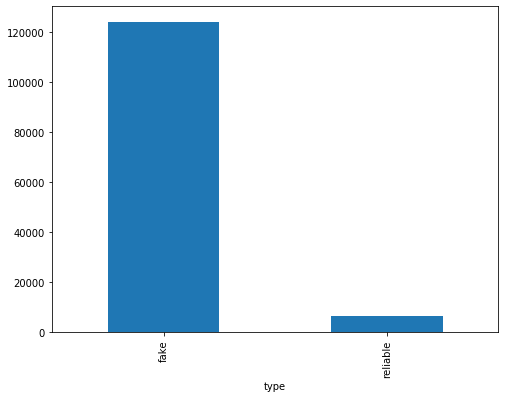

In [6]:
# plotting of categories

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('type').content.count().plot.bar(ylim=0)
plt.show()

,type,content
count,130530,130530
unique,2,115838
missing,0,0


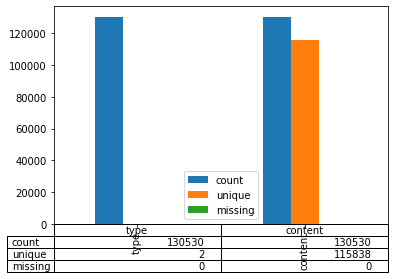

In [7]:
# Calculating number: count, unique for each column
describe_df = df.describe(include=[np.object]).head(2)

# Calculating number: NaN for each column
nan_df = df.isna().sum()

# Create one df
describe_df.loc['missing'] = nan_df
# plot
describe_df.T.plot(kind='bar',  table=True)
describe_df # just display numbers

### Dataset Preparation

Here we start the cleaning process. There are a lot of steps and the code can be a little complicated. Some steps have to be before others as they overrule the previous 

- how to implement is still up for debate as it can be smart to use small cells for each step or get all in one big cleaning step but display when they are done
- **READ** all excersice 1-7 on KU

### Common data cleaning steps
- make text all lower case
- remove puntuiation
- remove numerical values
- remove common non-sensial text(/n)
- tokanize text

### # steps that need to be included
- -NUM -DATE -EMAIL -URL
- replace nan with 'NULL'

### Text blob cleaning
The first cleaning-step is wokring on text blobs ie. all text at the same time

In [8]:
# working with content as a series
series_content = df['content']

### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###
sample_num = 3
before = series_content.iloc[sample_num]
### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###

### Order matters - (not final order of pipeline)
### Overall preprocessing

# lower_cast - NEEDED? - DONE by many libs
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

### replace [name] with tokens in text ###

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (Email_replace)"); series_content = series_content.replace(to_replace=regexEmail, value=' <EMAIL> ', regex=True)

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
%time print("\n (URL_replace)"); series_content = series_content.replace(to_replace=regexURL, value=' <URL> ', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (HTML_replace)"); series_content = series_content.replace(to_replace=regexHTML, value=' <HTML> ', regex=True)

# Date_replace - NOT DONE
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (Date_replace)"); series_content = series_content.replace(to_replace=regexDate, value=' <DATE> ', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # nums with [0-9] and [,.]
series_content = series_content.replace(to_replace=regexNum, value=' <NUM> ', regex=True)

### string removal functions ###
# New_line_remove
regexNEWLINE = r"\n|\\n"
%time print("\n (New_line_remove)"); series_content = series_content.replace(to_replace=regexNEWLINE, value=' ', regex=True)

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.…\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regwex if not needed
%time print("\n (Punctuation_remove)"); series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

# Non_ASCII_remove - Maybe a step too much
%time print("\n (Non_ASCII_remove)"); series_content = series_content.str.encode('ascii', 'ignore').str.decode('ascii')

# After all steps
print("\n (Done cleaning)")

### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###
print("[before]\n", repr(before), "\n\n[After]\n", repr(series_content.iloc[sample_num]) )
### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###


 (lower_cast)
Wall time: 2.15 s

 (Email_replace)
Wall time: 9.92 s

 (URL_replace)
Wall time: 42.2 s

 (HTML_replace)
Wall time: 423 ms

 (Date_replace)
Wall time: 2min 19s

 (New_line_remove)
Wall time: 3.82 s

 (Punctuation_remove)
Wall time: 4.67 s

 (Non_ASCII_remove)
Wall time: 613 ms

 (Done cleaning)
[before]
 'Shell Oil Company To Pay $80 Million To Nigeria Locals For ‘Devastating’ Oil Spill\n\nHeadline: Bitcoin & Blockchain Searches Exceed Trump! Blockchain Stocks Are Next!\n\nThe Royal Dutch Shell oil company has agreed to pay $84m (£55m) in compensation to a Nigerian community affected by oil spills in the Niger Delta. Fishermen and farmers whose livelihoods were destroyed by pollution will get more than $3,000 (£1,982) each, with the rest of the money going to the wider Bodo community.\n\nPrinceVega.com Facebook Fan Page: https://www.facebook.com/realprincevega?ref=hl\n\nSource: http://princevega.com/shell-oil-company-pay-80-million-nigeria-locals-devastating-oil-spill/' 

### Tokeniztion for futhere cleaning - slow step?

In [48]:
# tokenization and furthur cleaning

# This step might be much slower and therfore the least work should be done here

# tokenize text
token_list_series = series_content.str.split()
token_list_series

article_url
https://en.wikinews.org/wiki/Namibia_votes_in_presidential_election                                                     [voters, are, heading, to, the, polls, today, ...
https://en.wikinews.org/wiki/Scientology_defector_arrested_after_attempting_to_leave_organization                       [recent, reports, have, revealed, that, a, def...
https://en.wikinews.org/wiki/Nobel_laureate_Doris_Lessing:_9/11_%27wasn%27t_that_terrible%27_compared_to_IRA_attacks    [british, writer, doris, lessing, recipient, o...
https://en.wikinews.org/wiki/No-fly_zone_demanded_by_Syrian_protesters                                                  [friday, saw, protests, across, syria, calling...
https://en.wikinews.org/wiki/Romanian_oil_company_claims_Iran_has_seized_one_of_its_rigs                                [an, orizont, oil, platform, in, the, persian,...
                                                                                                                                          

## Cleaning for other colums

In [29]:
# to-do add case for words line Niel's thois is pt transalted into Niels

# Clean meta keywords representation
regexStrList = r"[\[\]']"
df['meta_keywords'] = df['meta_keywords'].replace(to_replace=regexStrList, value='', regex=True)

KeyError: 'meta_keywords'

## insert and write csv

In [9]:
# inset all changes and write csv file

df['content'] = series_content

# write csv
df.to_csv(return_file, index=True, header=True)

In [31]:
# series_content[series_content['content'].apply(regexDate)]

df =series_content.str.extract(r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*").isnull()

NameError: name 'series_content' is not defined

In [32]:
df1['mask'] = series_content.str.contains('(\d+[A-Z]+\d+)')


NameError: name 'series_content' is not defined

In [33]:
pat = r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
df_bool = series_content.str.contains(pat)

NameError: name 'series_content' is not defined

In [34]:
result = pd.DataFrame(series_content.str.extract(r'([\d]+)',expand=False))


NameError: name 'series_content' is not defined

In [35]:
from time import perf_counter 
t1_start = perf_counter()  
# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
series_content = series_content.replace(to_replace=regexURL, value='<URL>', regex=True)

# Stop the stopwatch / counter 
t1_stop = perf_counter() 
  
print("Elapsed time:", t1_stop, t1_start)  

NameError: name 'series_content' is not defined

In [36]:
import time
 
class MeasureDuration:
    def __init__(self):
        self.start = None
        self.end = None
 
    def __enter__(self):
        self.start = time.time()
        return self
 
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.time()
        print("Total time taken: %s" % self.duration())
 
    def duration(self):
        return str((self.end - self.start) * 1000) + ' milliseconds'

In [37]:
from time import time

class Timer():
    def __init__(self, message):
        self.message = message
    def __enter__(self):
        self.start = time()
        return None  # could return anything, to be used like this: with Timer("Message") as value:
    def __exit__(self, type, value, traceback):
        elapsed_time = (time() - self.start) * 1000
        print(self.message.format(elapsed_time))

In [38]:
df = pd.DataFrame({'x': [1, 2, 3, 4], 'y': [5, 6, 7, 8]})

# runs on single core
df['x2'] = df['x'].apply(lambda x: x**2)
# runs on multiple cores
df['x2'] = df['x'].swifter.apply(lambda x: x**2)

AttributeError: 'Series' object has no attribute 'swifter'

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.type_id
features.shape

AttributeError: 'DataFrame' object has no attribute 'content'

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['type_id'], df['content'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)clf = MultinomialNB().fit(X_train_tfidf, y_train)

SyntaxError: invalid syntax (<ipython-input-40-8ae1abe34dc4>, line 10)

In [41]:
def remove_stopwords(text): # words like 'the', 'a', 'me' - SLOW
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# def lower_cast(series_in): # Maybe not needed - lower casing is DONE my most of the modern day vecotirzers and tokenizers
#     """Lower Casing"""
#     return series_in.str.lower()

# def Email_replace(series_in):
#     """Replace emails with token"""
#     regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
#     return series_in.replace(to_replace=regexEmail, value='<EMAIL>', regex=True)

# def HTML_replace(series_in):
#     """REpalce HTML wiith token"""
#     regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
#     return series_in.replace(to_replace=regexHTML, value='<HTML>', regex=True)

# def Date_replace(series_in): # NOT WORKING PROBABLY - needs to be recreated
#     """Replace dates with token"""
#     # name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
#     # day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
#     # year         ([12][0-9]{3})         - Years from 1000 to 2999
#     regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
#     return series_in.replace(to_replace=regexDate, value='<DATE>', regex=True)

# def Number_replace(series_in): 
#     """Replace numbers with token"""
#     regexNum = r"[0-9][0-9,\.]+" # type of nums with [0-9] and [,.]
#     return series_in.replace(to_replace=regexNum, value='<NUM>', regex=True)

# def End_of_line_remove(series_in):
#     """Remove end_of_line \n"""
#     regexNL = r"(\\n)"
#     return series_in.replace(to_replace=regexNL, value=' ', regex=True)

# def Punctuation_remove(series_in): 
#     """Remove punctuations"""
#     regexPunkt = r"[!“”\"#$%&()*+,\-–.\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regex if not needed
#     series_in.replace(to_replace=regexPunkt, value='', regex=True)


In [42]:
### clean wiki ###

In [43]:
# importing and creating df (has to have type_id)

# usage: specify file location, sample size and seed(used by random) 
filepath = '../Data_sample/wiki_news_raw_backup.csv' # 250 rows of FakeNewsCorpus
s = 3679                                            # desired sample size
seed = 1                                           # seed used by Pseudorandom number generator

df = pd.read_csv(filepath, index_col = [0]).sample(n=s, random_state=seed)
df["content"] = df["content"].astype(str)

df.head()

,categories,content,publish_date,scraped_at,source_urls,sources_domain_urls,title
article_url,,,,,,,
https://en.wikinews.org/wiki/Namibia_votes_in_presidential_election,"November 28, 2009,Namibia,Published,Elections,...",\r\n Voters are heading to the polls today in ...,"November 28, 2009",2020-04-23,http://www1.voanews.com/english/news/africa/27...,"/wiki/VOA_News,/wiki/Associated_Press",Namibia votes in presidential election
https://en.wikinews.org/wiki/Scientology_defector_arrested_after_attempting_to_leave_organization,"October 9, 2010,Religion,Scientology,Published...",\r\n Recent reports have revealed that a defec...,"October 9, 2010",2020-04-22,http://newsfeed.time.com/2010/10/09/scientolog...,"/wiki/TIME,https://en.wikipedia.org/wiki/LA_We...",Scientology defector arrested after attempting...
https://en.wikinews.org/wiki/Nobel_laureate_Doris_Lessing:_9/11_%27wasn%27t_that_terrible%27_compared_to_IRA_attacks,"October 22, 2007,Published,Archived,United Kin...","\r\n British writer Doris Lessing , recipien...","October 22, 2007",2020-04-22,http://www.ctv.ca/servlet/ArticleNews/story/CT...,"https://en.wikipedia.org/wiki/CTV.ca,https://e...",Nobel laureate Doris Lessing: 9/11 'wasn't tha...
https://en.wikinews.org/wiki/No-fly_zone_demanded_by_Syrian_protesters,"October 29, 2011,Published,Archived,Syria,Midd...",\r\n Friday saw protests across Syria callin...,"October 29, 2011",2020-04-22,http://www.bbc.co.uk/news/world-middle-east-15...,"/wiki/BBC_News_Online,/wiki/Agence_France-Pres...",No-fly zone demanded by Syrian protesters
https://en.wikinews.org/wiki/Romanian_oil_company_claims_Iran_has_seized_one_of_its_rigs,"August 22, 2006,Published,AutoArchived,World,P...",\r\n An Orizont oil platform in the Persian G...,"August 22, 2006",2020-04-22,http://www.bloomberg.com/apps/news?pid=2060108...,"https://en.wikipedia.org/wiki/Bloomberg,/wiki/...",Romanian oil company claims Iran has seized on...


In [44]:
# working with content as a series
series_content = df['content']

### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###
sample_num = 3
before = series_content.iloc[sample_num]
### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###

### Order matters - (not final order of pipeline)
### Overall preprocessing

# lower_cast - NEEDED? - DONE by many libs
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

### replace [name] with tokens in text ###

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (Email_replace)"); series_content = series_content.replace(to_replace=regexEmail, value=' <EMAIL> ', regex=True)

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
%time print("\n (URL_replace)"); series_content = series_content.replace(to_replace=regexURL, value=' <URL> ', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (HTML_replace)"); series_content = series_content.replace(to_replace=regexHTML, value=' <HTML> ', regex=True)

# Date_replace - NOT DONE
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (Date_replace)"); series_content = series_content.replace(to_replace=regexDate, value=' <DATE> ', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # nums with [0-9] and [,.]
series_content = series_content.replace(to_replace=regexNum, value=' <NUM> ', regex=True)

### string removal functions ###
# New_line_remove
regexNEWLINE = r"\n|\\n"
%time print("\n (New_line_remove)"); series_content = series_content.replace(to_replace=regexNEWLINE, value=' ', regex=True)

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.…\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regwex if not needed
%time print("\n (Punctuation_remove)"); series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

# Non_ASCII_remove - Maybe a step too much
%time print("\n (Non_ASCII_remove)"); series_content = series_content.str.encode('ascii', 'ignore').str.decode('ascii')

# After all steps
print("\n (Done cleaning)")

### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###
print("[before]\n", repr(before), "\n\n[After]\n", repr(series_content.iloc[sample_num]) )
### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###


 (lower_cast)
Wall time: 30 ms

 (Email_replace)
Wall time: 175 ms

 (URL_replace)
Wall time: 760 ms

 (HTML_replace)
Wall time: 7 ms

 (Date_replace)
Wall time: 2.55 s

 (New_line_remove)
Wall time: 57 ms

 (Punctuation_remove)
Wall time: 79 ms

 (Non_ASCII_remove)
Wall time: 11 ms

 (Done cleaning)
[before]
 "\r\n Friday saw protests across  Syria  calling for a   to be imposed over the nation.  The protests are thought to have resulted in around 37 deaths.\r\n At least 170 different protests took place yesterday despite threatened violence as part of the growing unrest in the country. Demonstrators want the country's people to receive international protection against the autocratic rule of President  .\r\n Around 37 people are thought to have been killed in a police crackdown against the demonstrations, mostly in the cities of   and  . According to the  UN , more than 3,000 people have been killed since protests began in March.\r\n This wave of protests comes after the deposition o

## Cleaning for other colums

In [45]:
# to-do add case for words line Niel's thois is pt transalted into Niels

# Clean meta keywords representation
regexStrList = r".*?(.+? [0-9]{1,2}, [0-9]{4}).*"
df['publish_date'] = df['publish_date'].replace(to_replace=regexStrList, value=r'\1', regex=True)

## insert and write csv

In [46]:
# inset all changes and write csv file

df['content'] = series_content

# write csv
df.to_csv('../Data_git_ignore/wiki_news_raw_backup_clean.csv', index=True, header=True)